In [1]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

blocking_threshold = 0.9  #καθορισμός κατωφλίου (threshold) για την διακοπή διακτυακής κίνησης
nclass = 3
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/pcap_data.csv'


In [2]:
def loadDataset():
    # Put dataset path here !
    data = pd.read_csv(csv_file_path)

    X = data.drop('target', axis=1).values
    y = data['target'].values

    return X, y

In [3]:
# -- LOAD DATA -----------------------------------------------------------------
X, y = loadDataset()

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Test data 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Train 70%, Validation%10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train)

train_data, train_labelp, val_data, val_labelp, test_data, test_labelp = X_train.astype(
    'float32'), y_train.astype('int32'),  X_val.astype('float32'), y_val.astype(
        'int32'),  X_test.astype('float32'), y_test.astype('int32')

In [4]:
# to_categorical
train_label = to_categorical(train_labelp, nclass)
val_label   = to_categorical(val_labelp,   nclass)
test_label  = to_categorical(test_labelp,  nclass)

print('train_data.shape=', train_data.shape)
print('test_data.shape=',  test_data.shape)
print('test_data.shape=',  val_data.shape)

#get the number of features
inshape=train_data.shape[1]

# Class balancing weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(
                                                      train_labelp),
                                                  y=train_labelp)


class_weights = {i: class_weights[i] for i in range(len(class_weights))}

train_data.shape= (10476, 25)
test_data.shape= (2994, 25)
test_data.shape= (1497, 25)


In [5]:
# -- CALLBACKS -----------------------------------------------------------------
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=30,
                              verbose=0,
                              mode='min')

modelCheckPoint = ModelCheckpoint('./savemodels/model5class.weights.{epoch:03d}-{val_acc:.4f}.hdf5.keras',
                                  save_best_only=True,
                                  monitor='val_acc',
                                  mode='max')

In [6]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)

    #αποκλεισμός δικτυακής κυκλοφορίας εάν η προβλεπόμενη πιθανότητα υπερβαίνει το καθορισμένο όριο
    blocked_indices = np.where(y_pred_probs > blocking_threshold)[0]
    if len(blocked_indices) > 0:
        print(f"Blocking {len(blocked_indices)} malicious traffic instances.")

    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [8]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = loadDataset()

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return train_accuracies, test_accuracies

In [9]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
model = create_and_train_model(inshape)
train_accuracies, test_accuracies = simulate_streaming_lambda_architecture(model, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6311 - loss: 0.8191
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8445 - loss: 0.5003
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8696 - loss: 0.4505
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8803 - loss: 0.4306
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8894 - loss: 0.4094
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Blocking 7691 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1868 malicious traffic instances.
Batch 800, Training Accuracy: 0.9126, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6235 - loss: 0.8338
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8442 - loss: 0.5045
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8713 - loss: 0.4571
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8834 - loss: 0.4294
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8963 - loss: 0.3977
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Blocking 7023 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Blocking 1717 malicious traffic instances.
Batch 1600, Training Accuracy: 0.9144, Test Accuracy: 0.9041
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6500 - loss: 0.7991
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8474 - loss: 0.4870
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8742 - loss: 0.4327
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8828 - loss: 0.4212
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8920 - loss: 0.3994
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Blocking 7511 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1827 malicious traffic instances.
Batch 2400, Training Accuracy: 0.9148, Test Accuracy: 0.9041
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6443 - loss: 0.7939
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8470 - loss: 0.4996
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8712 - loss: 0.4582
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8839 - loss: 0.4246
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8927 - loss: 0.4009
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Blocking 7129 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Blocking 1765 malicious traffic instances.
Batch 3200, Training Accuracy: 0.9146, Test Accuracy: 0.9025
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6442 - loss: 0.7956
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8415 - loss: 0.5065
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8724 - loss: 0.4496
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8847 - loss: 0.4216
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8903 - loss: 0.4059
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Blocking 7409 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1779 malicious traffic instances.
Batch 4000, Training Accuracy: 0.9147, Test Accuracy: 0.9038
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6384 - loss: 0.7947
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8502 - loss: 0.4920
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8728 - loss: 0.4536
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8835 - loss: 0.4292
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8929 - loss: 0.4075
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Blocking 7672 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1872 malicious traffic instances.
Batch 4800, Training Accuracy: 0.9156, Test Accuracy: 0.9021
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6314 - loss: 0.8138
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8468 - loss: 0.5061
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8723 - loss: 0.4472
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8834 - loss: 0.4298
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8907 - loss: 0.4167
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Blocking 7905 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1938 malicious traffic instances.
Batch 5600, Training Accuracy: 0.9132, Test Accuracy: 0.9025
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6186 - loss: 0.8243
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8449 - loss: 0.5048
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8676 - loss: 0.4573
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8853 - loss: 0.4238
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8944 - loss: 0.4014
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Blocking 7409 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1823 malicious traffic instances.
Batch 6400, Training Accuracy: 0.9140, Test Accuracy: 0.9031
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6334 - loss: 0.8173
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8388 - loss: 0.5034
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8768 - loss: 0.4413
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8883 - loss: 0.4152
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8926 - loss: 0.4093
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Blocking 7509 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1830 malicious traffic instances.
Batch 7200, Training Accuracy: 0.9126, Test Accuracy: 0.9011
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6271 - loss: 0.8207
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8504 - loss: 0.4862
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8758 - loss: 0.4378
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8835 - loss: 0.4239
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8942 - loss: 0.3907
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Blocking 7845 malicious traffic instances.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1911 malicious traffic instances.
Batch 8000, Training Accuracy: 0.9147, Test Accuracy: 0.9038


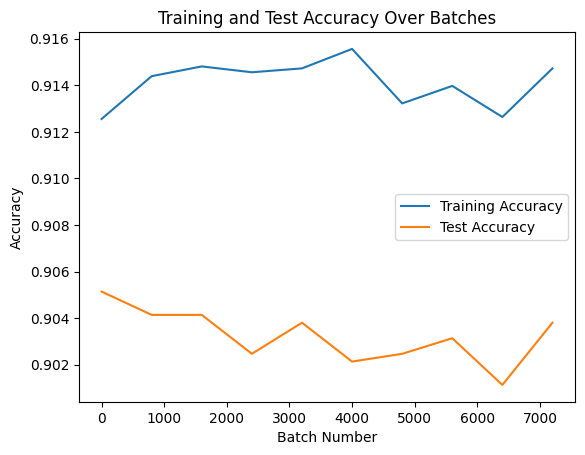

In [10]:
total_batches = 8000
retrain_every_batches = 800
#εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Batches')
plt.legend()
plt.show()